In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets
from torchvision.transforms import ToTensor

## Source

Followed [PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) and [this medium article](https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118) for initial setup of CNN network trained and tested using MNIST.

## Download the MNIST Dataset

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

## Plot Examples

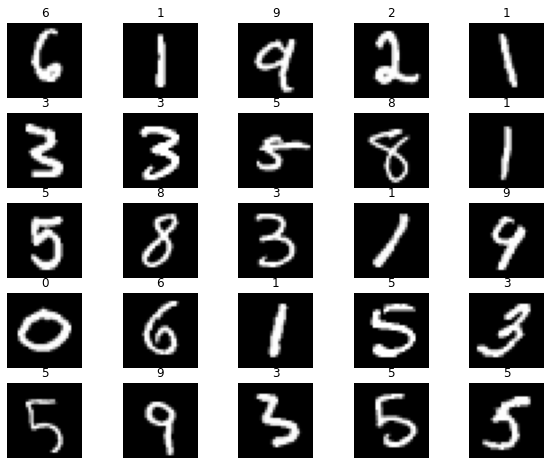

In [3]:
cols, rows = 5, 5
fig, ax = plt.subplots(cols, rows, figsize=(10, 8))

for i in range(cols * rows):
    col, row = i // 5, i % 5
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    ax[col, row].set_title(label)
    ax[col, row].axis("off")
    ax[col, row].imshow(img.squeeze(), cmap="gray")


## DataLoaders

In [4]:
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=100, 
    shuffle=True, 
    num_workers=1
)
    
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=100, 
    shuffle=True, 
    num_workers=1
)

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x11c76dca0>,
 <torch.utils.data.dataloader.DataLoader at 0x11c76dd30>)

## Network Definition

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=16,
            kernel_size=5,
            stride=1,
            padding=0,
        )
        self.pool = nn.MaxPool2d(
            kernel_size=2
        )
        self.conv2 = nn.Conv2d(
            in_channels=1,
            out_channels=16,
            kernel_size=5,
            # stride=1,
            # padding=2,
        )
        self.fc = nn.Linear(
            in_features=16*12*12,
            out_features=10
        )


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x    # return x for visualization

In [6]:
cnn = CNN()
cnn

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=2304, out_features=10, bias=True)
)

In [7]:
criterion = nn.CrossEntropyLoss()   
criterion

CrossEntropyLoss()

In [8]:
optimizer = optim.Adam(cnn.parameters(), lr=0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

## Training

In [9]:
num_epochs = 10
total_step = len(train_loader)

cnn.train()
    
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        b_x = Variable(inputs, requires_grad=True)
        b_y = Variable(labels)
    
        output = cnn(b_x)
        loss = criterion(output, b_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')

Epoch [1/10], Step [100/600], Loss: 0.2078
Epoch [1/10], Step [200/600], Loss: 0.0952
Epoch [1/10], Step [300/600], Loss: 0.2160
Epoch [1/10], Step [400/600], Loss: 0.0315
Epoch [1/10], Step [500/600], Loss: 0.1077
Epoch [1/10], Step [600/600], Loss: 0.0607
Epoch [2/10], Step [100/600], Loss: 0.0420
Epoch [2/10], Step [200/600], Loss: 0.0073
Epoch [2/10], Step [300/600], Loss: 0.1759
Epoch [2/10], Step [400/600], Loss: 0.0363
Epoch [2/10], Step [500/600], Loss: 0.0342
Epoch [2/10], Step [600/600], Loss: 0.0297
Epoch [3/10], Step [100/600], Loss: 0.0142
Epoch [3/10], Step [200/600], Loss: 0.1746
Epoch [3/10], Step [300/600], Loss: 0.0481
Epoch [3/10], Step [400/600], Loss: 0.0100
Epoch [3/10], Step [500/600], Loss: 0.0738
Epoch [3/10], Step [600/600], Loss: 0.0425
Epoch [4/10], Step [100/600], Loss: 0.0471
Epoch [4/10], Step [200/600], Loss: 0.0812
Epoch [4/10], Step [300/600], Loss: 0.0010
Epoch [4/10], Step [400/600], Loss: 0.0545
Epoch [4/10], Step [500/600], Loss: 0.1310
Epoch [4/10

## Testing

In [10]:
cnn.eval()

for inputs, labels in test_loader:
    test_output = cnn(inputs)
    pred_y = torch.max(test_output, 1).indices
    accuracy = (pred_y == labels).sum().item() / float(labels.size(0))

print(f'Test Accuracy: {accuracy:.2f}')

Test Accuracy: 0.99


## Adversarial Examples

In [35]:
cnn.eval()

epsilon = 0.07

orig_preds = torch.max(cnn(b_x.data), 1).indices
grad_preds = torch.max(cnn(np.sign(b_x.grad.sign())), 1).indices
adv_preds = torch.max(cnn(b_x.data + epsilon*np.sign(b_x.grad)), 1).indices

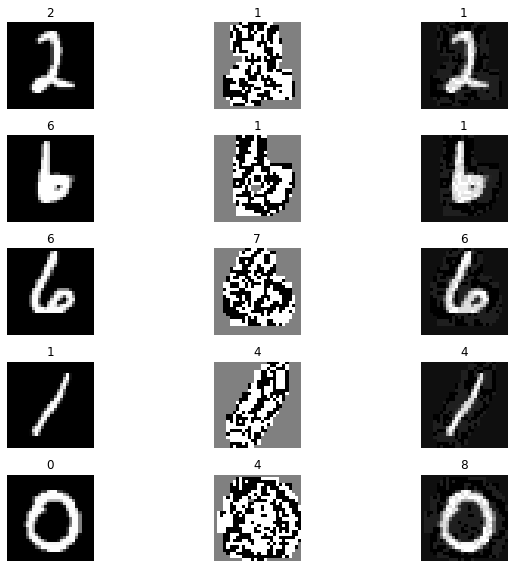

In [37]:
example_start_ind = 0
n_examples = 5
fig, ax = plt.subplots(n_examples, 3, figsize=(10, 8))
for i, j in enumerate(range(example_start_ind, example_start_ind+n_examples)):
    orig_img = b_x.data[j, :, :, :].squeeze()
    grad_img = (b_x.grad.sign())[j, :, :, :].squeeze()
    adv_img = orig_img + epsilon*grad_img

    ax[i,0].imshow(orig_img, cmap="gray")
    ax[i,0].set_title(orig_preds[j].item())
    ax[i,0].axis('off')

    ax[i,1].imshow(grad_img, cmap="gray")
    ax[i,1].set_title(grad_preds[j].item())
    ax[i,1].axis('off')

    ax[i,2].imshow(adv_img, cmap="gray")
    ax[i,2].set_title(adv_preds[j].item())
    ax[i,2].axis('off')
fig.tight_layout()

In [13]:
# cnn.eval()

# for i, (inputs, labels) in enumerate(train_loader):
#     b_x = Variable(inputs, requires_grad=True)
#     output = cnn(b_x)
#     loss = criterion(output, b_y)
#     optimizer.zero_grad()
#     loss.backward()

In [14]:
# test_output = cnn(b_x.grad.sign())
# pred_y = torch.max(test_output, 1).indices
# pred_y